# Business Problem
Navigating the intricate landscape of healthcare, the challenge of patient readmission emerges as a critical concern that demands innovative solutions. Patient readmission, or the return of a patient to the hospital shortly after discharge, not only poses a significant financial burden on healthcare systems but also underscores potential gaps in patient care. High rates of readmission often signal unresolved health issues, insufficient post-discharge support, or inadequate coordination among healthcare providers. This recurrent cycle not only impacts the well-being of patients but also places additional strain on healthcare resources.

Addressing the problem of patient readmission is not merely about reducing costs; it is fundamentally rooted in a commitment to enhancing the overall quality of patient care, ensuring seamless transitions between hospital and home, and ultimately fostering a healthcare system that prioritizes sustained well-being and optimal recovery.

# Technical Problem
With MediWatch, our aim is to design a predictive model to assess and anticipate the likelihood of patient readmission.

MediWatch analyzes a myriad of patient-specific factors, such as medical history, demographic information, treatment protocols, post-discharge follow-ups etc. to generate a comprehensive prediction model. The system aims to proactively identify individuals at a higher risk of readmission, allowing healthcare providers to implement targeted interventions and personalized care plans.

Authors:
  - Kashyap K. R. Kambhatla, Ph.D.
  - Aaron Nicholson

In [4]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [5]:
import os
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
lazypredict.__version__

'0.2.12'

In [9]:
cur_dir = os.getcwd()
input_data_folder = os.path.join(cur_dir, 'input_data')

In [10]:
# Create the input_data folder if it doesn't exist
if not os.path.exists(input_data_folder):
    os.makedirs(input_data_folder)

In [11]:
# Download the dataset
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"
dataset_zip_path = os.path.join(input_data_folder, 'dataset_diabetes.zip')

In [12]:
# Download the file
response = requests.get(dataset_url)
with open(dataset_zip_path, 'wb') as f:
    f.write(response.content)

In [13]:
# Unzip the dataset
import zipfile
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(input_data_folder)

In [14]:
# Load the dataset into a DataFrame
data_file_path = os.path.join(input_data_folder, 'dataset_diabetes/diabetic_data.csv')
df= pd.read_csv(data_file_path)

## Common Functions

In [17]:
#Checking the unique values of the columns
def get_unique_values(data):
  for col in data.columns:
    print(f"Unique values of {col}: {data[col].unique()}")

In [16]:
def get_rows_columns_dtypes(data):
    # Print the shape
    # Overview of dataframe
    rows = data.shape[0]
    cols = data.shape[1]
    print('#samples  (rows)    =  {}'.format(rows))
    print('#features (columns) =  {}'.format(cols))
    
    # Print the data types dtypes
    print("\nData types:\n", data.dtypes)

In [22]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
def check_missing_values(data):
  for col in data.columns:
    num_missing = data[col][data[col] == '?'].count()
    percent_missing = (data[col] == '?').mean() * 100
    print(f'{col},\t {num_missing},\t {percent_missing:.2f}%')

In [66]:
# get list of only numeric features
def get_numeric_features(data, forecast_column=None):
    if forecast_column:
        return(list(set(list(df._get_numeric_data().columns))- {forecast_column}))
    return(list(set(list(df._get_numeric_data().columns))))

In [63]:
# get list of only categorical features
def get_categorical_features(data, col_exclude=None):
    cat_col = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    if col_exclude:
        cat_col = list(set(cat_col) - set(col_exclude))
    return(cat_col)

In [78]:
# standardize function
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

## Data Cleaning

In [20]:
# First 10 rows of the dataset
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
weight,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12


In [21]:
# Shape and dtypes
get_rows_columns_dtypes(df)

#samples  (rows)    =  101766
#features (columns) =  50

Data types:
 encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide         

In [23]:
check_missing_values(df)

encounter_id,	 0,	 0.00%
patient_nbr,	 0,	 0.00%
race,	 2273,	 2.23%
gender,	 0,	 0.00%
age,	 0,	 0.00%
weight,	 98569,	 96.86%
admission_type_id,	 0,	 0.00%
discharge_disposition_id,	 0,	 0.00%
admission_source_id,	 0,	 0.00%
time_in_hospital,	 0,	 0.00%
payer_code,	 40256,	 39.56%
medical_specialty,	 49949,	 49.08%
num_lab_procedures,	 0,	 0.00%
num_procedures,	 0,	 0.00%
num_medications,	 0,	 0.00%
number_outpatient,	 0,	 0.00%
number_emergency,	 0,	 0.00%
number_inpatient,	 0,	 0.00%
diag_1,	 21,	 0.02%
diag_2,	 358,	 0.35%
diag_3,	 1423,	 1.40%
number_diagnoses,	 0,	 0.00%
max_glu_serum,	 0,	 0.00%
A1Cresult,	 0,	 0.00%
metformin,	 0,	 0.00%
repaglinide,	 0,	 0.00%
nateglinide,	 0,	 0.00%
chlorpropamide,	 0,	 0.00%
glimepiride,	 0,	 0.00%
acetohexamide,	 0,	 0.00%
glipizide,	 0,	 0.00%
glyburide,	 0,	 0.00%
tolbutamide,	 0,	 0.00%
pioglitazone,	 0,	 0.00%
rosiglitazone,	 0,	 0.00%
acarbose,	 0,	 0.00%
miglitol,	 0,	 0.00%
troglitazone,	 0,	 0.00%
tolazamide,	 0,	 0.00%
examide,	 0

In [25]:
# gender was coded differently so we use a custom count for this one            
print('Missing values in gender:', df['gender'][df['gender'] == 'Unknown/Invalid'].count())

Missing values in gender: 3


Variable weight contains approximate 98% of the missing values so there is no significance in filling those missing values so we decided to drop these variables. Variable Payer code and medical specialty contains approximate 40% or mpre missing values so we also dropped these variables. 

In [27]:
# Drop weight, payer_code, and medical_speciality features
df = df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

Variables race, diag_1, diag_2, diag_3 and gender contains very less missing values as compared to other attributes which we dropped so for these attributes we also decided to drop those where missing values contains.

In [26]:
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(df['diag_1'][df['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_2'][df['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_3'][df['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['race'][df['race'] == '?'].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

variables (drugs named citoglipton and examide), all records have the same value. So essentially these cannot provide any interpretive or discriminatory information for predicting readmission so we decided to drop these two variables

In [28]:
df = df.drop(['citoglipton', 'examide'], axis = 1)

In [29]:
# Check missing values
check_missing_values(df)

encounter_id,	 0,	 0.00%
patient_nbr,	 0,	 0.00%
race,	 0,	 0.00%
gender,	 0,	 0.00%
age,	 0,	 0.00%
admission_type_id,	 0,	 0.00%
discharge_disposition_id,	 0,	 0.00%
admission_source_id,	 0,	 0.00%
time_in_hospital,	 0,	 0.00%
num_lab_procedures,	 0,	 0.00%
num_procedures,	 0,	 0.00%
num_medications,	 0,	 0.00%
number_outpatient,	 0,	 0.00%
number_emergency,	 0,	 0.00%
number_inpatient,	 0,	 0.00%
diag_1,	 0,	 0.00%
diag_2,	 0,	 0.00%
diag_3,	 0,	 0.00%
number_diagnoses,	 0,	 0.00%
max_glu_serum,	 0,	 0.00%
A1Cresult,	 0,	 0.00%
metformin,	 0,	 0.00%
repaglinide,	 0,	 0.00%
nateglinide,	 0,	 0.00%
chlorpropamide,	 0,	 0.00%
glimepiride,	 0,	 0.00%
acetohexamide,	 0,	 0.00%
glipizide,	 0,	 0.00%
glyburide,	 0,	 0.00%
tolbutamide,	 0,	 0.00%
pioglitazone,	 0,	 0.00%
rosiglitazone,	 0,	 0.00%
acarbose,	 0,	 0.00%
miglitol,	 0,	 0.00%
troglitazone,	 0,	 0.00%
tolazamide,	 0,	 0.00%
insulin,	 0,	 0.00%
glyburide-metformin,	 0,	 0.00%
glipizide-metformin,	 0,	 0.00%
glimepiride-pioglitazon

In [30]:
# Check missing values in gender           
print('Missing values in gender:', df['gender'][df['gender'] == 'Unknown/Invalid'].count())

Missing values in gender: 0


## Feature Engineering

### Service utilization
The data contains variables for number of inpatient (admissions), emergency room visits and outpatient visits for a given patient in the previous one year. These are (crude) measures of how much hospital/clinic services a person has used in the past year. We added these three to create a new variable called service utilization (see figure below). The idea was to see which version gives us better results. Granted, we did not apply any special weighting to the three ingredients of service utilization but we wanted to try something simple at this stage.

In [31]:
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

### Number of medication changes
The dataset contains 23 features for 23 drugs (or combos) which indicate for each of these, whether a change in that medication was made or not during the current hospital stay of patient. Medication change for diabetics upon admission has been shown by previous research to be associated with lower readmission rates. We decided to count how many changes were made in total for each patient, and declared that a new feature. The reasoning here was to both simplify the model and possibly discover a relationship with number of changes regardless of which drug was changed.

In [32]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]
    
df['numchange'].value_counts()

0    70142
1    24922
2     1271
3      106
4        5
Name: numchange, dtype: int64

In [33]:
# re-encoding admission type, discharge type and admission source into fewer categories
df['admission_type_id'] = df['admission_type_id'].replace(2,1)
df['admission_type_id'] = df['admission_type_id'].replace(7,1)
df['admission_type_id'] = df['admission_type_id'].replace(6,5)
df['admission_type_id'] = df['admission_type_id'].replace(8,5)

df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(6,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(8,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(9,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(13,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(3,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(4,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(5,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(14,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(22,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(23,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(12,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(15,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(16,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(17,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(25,18)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(26,18)

df['admission_source_id'] = df['admission_source_id'].replace(2,1)
df['admission_source_id'] = df['admission_source_id'].replace(3,1)
df['admission_source_id'] = df['admission_source_id'].replace(5,4)
df['admission_source_id'] = df['admission_source_id'].replace(6,4)
df['admission_source_id'] = df['admission_source_id'].replace(10,4)
df['admission_source_id'] = df['admission_source_id'].replace(22,4)
df['admission_source_id'] = df['admission_source_id'].replace(25,4)
df['admission_source_id'] = df['admission_source_id'].replace(15,9)
df['admission_source_id'] = df['admission_source_id'].replace(17,9)
df['admission_source_id'] = df['admission_source_id'].replace(20,9)
df['admission_source_id'] = df['admission_source_id'].replace(21,9)
df['admission_source_id'] = df['admission_source_id'].replace(13,11)
df['admission_source_id'] = df['admission_source_id'].replace(14,11)

### Encoding some variables 
The original dataset used string values for gender, race, medication change, and each of the 23 drugs used. To better fit those variables into our model, we interpret the variables to numeric binary variables to reflect their nature. For example, we encoded the “ medication change ” feature from “No” (no change) and “Ch” (changed) into 0 and 1.

In [36]:
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)
# keys is the same as before
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)

We also reduced both A1C test result and Glucose serum test result into categories of Normal, Abnormal and Not tested.

In [35]:
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)
df['A1Cresult'] = df['A1Cresult'].fillna(-99)
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)
df['max_glu_serum'] = df['max_glu_serum'].fillna(-99)

### Dealing with age:
There are different ways to deal with this. The dataset only gives us age as 10 year categories, so we don’t know the exact age of each patient. The previous study on this dataset used age categories as nominal variables, but we wanted to be able to see the effect of increasing age on readmission, even if in a crude way. To do that, we assume that age of the patient on average lies at the midpoint of the age category. For example, if the patient’s age category is 20–30 years, then we assume the age = 25 years. So we converted age categories to midpoints, resulting in a numeric variable:

In [37]:
# code age intervals [0-10) - [90-100) from 1-10
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
df['age'].value_counts()

8     24815
7     21521
6     16546
9     16223
5      9208
4      3538
10     2594
3      1471
2       466
1        64
Name: age, dtype: int64

### Collapsing of Multiple Encounters for same patient 
Some patients in the dataset had more than one encounter.We could not count them as independent encounters because that bias the results towards those patients who had multiple encounters. Thus we tried multiple techniques to collapse and consolidate multiple encounters for same patient such as:

* Considering more than 2 readmissions across multiple encounters as readmission for collapsed record.
* Considering average stay at hospital across multiple encounters.
* Considering the percentage of the medication changes across multiple encounters
* Considering the total number of the encounters to replace the encounter unique ID
* Considering the combination of diagnoses across multiple encounters as a list However, taking the features such as “diagnosis”, for instance, we did not find it not meaningful to combine multiple categorical values into an array for building data model. We then considered first encounter and last encounter separately as possible representations of multiple encounters. However, last encounters gave extremely imbalanced data for readmissions (96/4 Readmissions vs No Readmissions) and thus, we decided to use first encounters of patients with multiple encounters. This resulted in dataset being reduced to about 70,000 encounters:

In [38]:
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape

(67580, 47)

In [39]:
df.head().T

,1,2,3,4,5
encounter_id,149190,64410,500364,16680,35754
patient_nbr,55629189,86047875,82442376,42519267,82637451
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,0,0,1,1,1
age,2,3,4,5,6
admission_type_id,1,1,1,1,1
discharge_disposition_id,1,1,1,1,1
admission_source_id,7,7,7,7,1
time_in_hospital,3,2,2,1,3
num_lab_procedures,59,11,44,51,31


### Encoding the outcome variable: 
The outcome we are looking at is whether the patient gets readmitted to the hospital within 30 days or not. The variable actually has < 30, > 30 and No Readmission categories. To reduce our problem to a binary classification, we combined the readmission after 30 days and no readmission into a single category:

In [40]:
df['readmitted'].value_counts()

NO     50731
>30    34649
<30    11066
Name: readmitted, dtype: int64

In [41]:
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

###  Categorization of diagnoses: 
The dataset contained up to three diagnoses for a given patient (primary, secondary and additional). However, each of these had 700–900 unique ICD codes and it is extremely difficult to include them in the model and interpret meaningfully. Therefore, we collapsed these diagnosis codes into 9 disease categories in an almost similar fashion to that done in the original publication using this dataset. These 9 categories include Circulatory, Respiratory, Digestive, Diabetes, Injury, Musculoskeletal, Genitourinary, Neoplasms, and Others. Although we did this for primary, secondary and additional diagnoses, we eventually decided to use only the primary diagnosis in our model. Doing this in python was slightly cumbersome because, well, we are mapping the disease codes to certain category names. Below code should demonstrate this easily.

In [42]:
# Creating additional columns for diagnosis 
df['level1_diag1'] = df['diag_1']
df['level2_diag1'] = df['diag_1']
df['level1_diag2'] = df['diag_2']
df['level2_diag2'] = df['diag_2']
df['level1_diag3'] = df['diag_3']
df['level2_diag3'] = df['diag_3']

In [43]:
df.loc[df['diag_1'].str.contains('V'), ['level1_diag1', 'level2_diag1']] = 0
df.loc[df['diag_1'].str.contains('E'), ['level1_diag1', 'level2_diag1']] = 0
df.loc[df['diag_2'].str.contains('V'), ['level1_diag2', 'level2_diag2']] = 0
df.loc[df['diag_2'].str.contains('E'), ['level1_diag2', 'level2_diag2']] = 0
df.loc[df['diag_3'].str.contains('V'), ['level1_diag3', 'level2_diag3']] = 0
df.loc[df['diag_3'].str.contains('E'), ['level1_diag3', 'level2_diag3']] = 0
df['level1_diag1'] = df['level1_diag1'].replace('?', -1)
df['level2_diag1'] = df['level2_diag1'].replace('?', -1)
df['level1_diag2'] = df['level1_diag2'].replace('?', -1)
df['level2_diag2'] = df['level2_diag2'].replace('?', -1)
df['level1_diag3'] = df['level1_diag3'].replace('?', -1)
df['level2_diag3'] = df['level2_diag3'].replace('?', -1)

In [44]:
df['level1_diag1'] = df['level1_diag1'].astype(float)
df['level2_diag1'] = df['level2_diag1'].astype(float)
df['level1_diag2'] = df['level1_diag2'].astype(float)
df['level2_diag2'] = df['level2_diag2'].astype(float)
df['level1_diag3'] = df['level1_diag3'].astype(float)
df['level2_diag3'] = df['level2_diag3'].astype(float)

In [45]:
for index, row in df.iterrows():
    if (row['level1_diag1'] >= 390 and row['level1_diag1'] < 460) or (np.floor(row['level1_diag1']) == 785):
        df.loc[index, 'level1_diag1'] = 1
    elif (row['level1_diag1'] >= 460 and row['level1_diag1'] < 520) or (np.floor(row['level1_diag1']) == 786):
        df.loc[index, 'level1_diag1'] = 2
    elif (row['level1_diag1'] >= 520 and row['level1_diag1'] < 580) or (np.floor(row['level1_diag1']) == 787):
        df.loc[index, 'level1_diag1'] = 3
    elif (np.floor(row['level1_diag1']) == 250):
        df.loc[index, 'level1_diag1'] = 4
    elif (row['level1_diag1'] >= 800 and row['level1_diag1'] < 1000):
        df.loc[index, 'level1_diag1'] = 5
    elif (row['level1_diag1'] >= 710 and row['level1_diag1'] < 740):
        df.loc[index, 'level1_diag1'] = 6
    elif (row['level1_diag1'] >= 580 and row['level1_diag1'] < 630) or (np.floor(row['level1_diag1']) == 788):
        df.loc[index, 'level1_diag1'] = 7
    elif (row['level1_diag1'] >= 140 and row['level1_diag1'] < 240):
        df.loc[index, 'level1_diag1'] = 8
    else:
        df.loc[index, 'level1_diag1'] = 0
        
    if (row['level1_diag2'] >= 390 and row['level1_diag2'] < 460) or (np.floor(row['level1_diag2']) == 785):
        df.loc[index, 'level1_diag2'] = 1
    elif (row['level1_diag2'] >= 460 and row['level1_diag2'] < 520) or (np.floor(row['level1_diag2']) == 786):
        df.loc[index, 'level1_diag2'] = 2
    elif (row['level1_diag2'] >= 520 and row['level1_diag2'] < 580) or (np.floor(row['level1_diag2']) == 787):
        df.loc[index, 'level1_diag2'] = 3
    elif (np.floor(row['level1_diag2']) == 250):
        df.loc[index, 'level1_diag2'] = 4
    elif (row['level1_diag2'] >= 800 and row['level1_diag2'] < 1000):
        df.loc[index, 'level1_diag2'] = 5
    elif (row['level1_diag2'] >= 710 and row['level1_diag2'] < 740):
        df.loc[index, 'level1_diag2'] = 6
    elif (row['level1_diag2'] >= 580 and row['level1_diag2'] < 630) or (np.floor(row['level1_diag2']) == 788):
        df.loc[index, 'level1_diag2'] = 7
    elif (row['level1_diag2'] >= 140 and row['level1_diag2'] < 240):
        df.loc[index, 'level1_diag2'] = 8
    else:
        df.loc[index, 'level1_diag2'] = 0
    
    if (row['level1_diag3'] >= 390 and row['level1_diag3'] < 460) or (np.floor(row['level1_diag3']) == 785):
        df.loc[index, 'level1_diag3'] = 1
    elif (row['level1_diag3'] >= 460 and row['level1_diag3'] < 520) or (np.floor(row['level1_diag3']) == 786):
        df.loc[index, 'level1_diag3'] = 2
    elif (row['level1_diag3'] >= 520 and row['level1_diag3'] < 580) or (np.floor(row['level1_diag3']) == 787):
        df.loc[index, 'level1_diag3'] = 3
    elif (np.floor(row['level1_diag3']) == 250):
        df.loc[index, 'level1_diag3'] = 4
    elif (row['level1_diag3'] >= 800 and row['level1_diag3'] < 1000):
        df.loc[index, 'level1_diag3'] = 5
    elif (row['level1_diag3'] >= 710 and row['level1_diag3'] < 740):
        df.loc[index, 'level1_diag3'] = 6
    elif (row['level1_diag3'] >= 580 and row['level1_diag3'] < 630) or (np.floor(row['level1_diag3']) == 788):
        df.loc[index, 'level1_diag3'] = 7
    elif (row['level1_diag3'] >= 140 and row['level1_diag3'] < 240):
        df.loc[index, 'level1_diag3'] = 8
    else:
        df.loc[index, 'level1_diag3'] = 0

In [46]:
for index, row in df.iterrows():
    if (row['level2_diag1'] >= 390 and row['level2_diag1'] < 399):
        df.loc[index, 'level2_diag1'] = 1
    elif (row['level2_diag1'] >= 401 and row['level2_diag1'] < 415):
        df.loc[index, 'level2_diag1'] = 2
    elif (row['level2_diag1'] >= 415 and row['level2_diag1'] < 460):
        df.loc[index, 'level2_diag1'] = 3
    elif (np.floor(row['level2_diag1']) == 785):
        df.loc[index, 'level2_diag1'] = 4
    elif (row['level2_diag1'] >= 460 and row['level2_diag1'] < 489):
        df.loc[index, 'level2_diag1'] = 5
    elif (row['level2_diag1'] >= 490 and row['level2_diag1'] < 497):
        df.loc[index, 'level2_diag1'] = 6
    elif (row['level2_diag1'] >= 500 and row['level2_diag1'] < 520):
        df.loc[index, 'level2_diag1'] = 7
    elif (np.floor(row['level2_diag1']) == 786):
        df.loc[index, 'level2_diag1'] = 8
    elif (row['level2_diag1'] >= 520 and row['level2_diag1'] < 530):
        df.loc[index, 'level2_diag1'] = 9
    elif (row['level2_diag1'] >= 530 and row['level2_diag1'] < 544):
        df.loc[index, 'level2_diag1'] = 10
    elif (row['level2_diag1'] >= 550 and row['level2_diag1'] < 554):
        df.loc[index, 'level2_diag1'] = 11
    elif (row['level2_diag1'] >= 555 and row['level2_diag1'] < 580):
        df.loc[index, 'level2_diag1'] = 12
    elif (np.floor(row['level2_diag1']) == 787):
        df.loc[index, 'level2_diag1'] = 13
    elif (np.floor(row['level2_diag1']) == 250):
        df.loc[index, 'level2_diag1'] = 14
    elif (row['level2_diag1'] >= 800 and row['level2_diag1'] < 1000):
        df.loc[index, 'level2_diag1'] = 15
    elif (row['level2_diag1'] >= 710 and row['level2_diag1'] < 740):
        df.loc[index, 'level2_diag1'] = 16
    elif (row['level2_diag1'] >= 580 and row['level2_diag1'] < 630):
        df.loc[index, 'level2_diag1'] = 17
    elif (np.floor(row['level2_diag1']) == 788):
        df.loc[index, 'level2_diag1'] = 18
    elif (row['level2_diag1'] >= 140 and row['level2_diag1'] < 240):
        df.loc[index, 'level2_diag1'] = 19
    elif row['level2_diag1'] >= 240 and row['level2_diag1'] < 280 and (np.floor(row['level2_diag1']) != 250):
        df.loc[index, 'level2_diag1'] = 20
    elif (row['level2_diag1'] >= 680 and row['level2_diag1'] < 710) or (np.floor(row['level2_diag1']) == 782):
        df.loc[index, 'level2_diag1'] = 21
    elif (row['level2_diag1'] >= 290 and row['level2_diag1'] < 320):
        df.loc[index, 'level2_diag1'] = 22
    else:
        df.loc[index, 'level2_diag1'] = 0

    if (row['level2_diag2'] >= 390 and row['level2_diag2'] < 399):
        df.loc[index, 'level2_diag2'] = 1
    elif (row['level2_diag2'] >= 401 and row['level2_diag2'] < 415):
        df.loc[index, 'level2_diag2'] = 2
    elif (row['level2_diag2'] >= 415 and row['level2_diag2'] < 460):
        df.loc[index, 'level2_diag2'] = 3
    elif (np.floor(row['level2_diag2']) == 785):
        df.loc[index, 'level2_diag2'] = 4
    elif (row['level2_diag2'] >= 460 and row['level2_diag2'] < 489):
        df.loc[index, 'level2_diag2'] = 5
    elif (row['level2_diag2'] >= 490 and row['level2_diag2'] < 497):
        df.loc[index, 'level2_diag2'] = 6
    elif (row['level2_diag2'] >= 500 and row['level2_diag2'] < 520):
        df.loc[index, 'level2_diag2'] = 7
    elif (np.floor(row['level2_diag2']) == 786):
        df.loc[index, 'level2_diag2'] = 8
    elif (row['level2_diag2'] >= 520 and row['level2_diag2'] < 530):
        df.loc[index, 'level2_diag2'] = 9
    elif (row['level2_diag2'] >= 530 and row['level2_diag2'] < 544):
        df.loc[index, 'level2_diag2'] = 10
    elif (row['level2_diag2'] >= 550 and row['level2_diag2'] < 554):
        df.loc[index, 'level2_diag2'] = 11
    elif (row['level2_diag2'] >= 555 and row['level2_diag2'] < 580):
        df.loc[index, 'level2_diag2'] = 12
    elif (np.floor(row['level2_diag2']) == 787):
        df.loc[index, 'level2_diag2'] = 13
    elif (np.floor(row['level2_diag2']) == 250):
        df.loc[index, 'level2_diag2'] = 14
    elif (row['level2_diag2'] >= 800 and row['level2_diag2'] < 1000):
        df.loc[index, 'level2_diag2'] = 15
    elif (row['level2_diag2'] >= 710 and row['level2_diag2'] < 740):
        df.loc[index, 'level2_diag2'] = 16
    elif (row['level2_diag2'] >= 580 and row['level2_diag2'] < 630):
        df.loc[index, 'level2_diag2'] = 17
    elif (np.floor(row['level2_diag2']) == 788):
        df.loc[index, 'level2_diag2'] = 18
    elif (row['level2_diag2'] >= 140 and row['level2_diag2'] < 240):
        df.loc[index, 'level2_diag2'] = 19
    elif row['level2_diag2'] >= 240 and row['level2_diag2'] < 280 and (np.floor(row['level2_diag2']) != 250):
        df.loc[index, 'level2_diag2'] = 20
    elif (row['level2_diag2'] >= 680 and row['level2_diag2'] < 710) or (np.floor(row['level2_diag2']) == 782):
        df.loc[index, 'level2_diag2'] = 21
    elif (row['level2_diag2'] >= 290 and row['level2_diag2'] < 320):
        df.loc[index, 'level2_diag2'] = 22
    else:
        df.loc[index, 'level2_diag2'] = 0

    if (row['level2_diag3'] >= 390 and row['level2_diag3'] < 399):
        df.loc[index, 'level2_diag3'] = 1
    elif (row['level2_diag3'] >= 401 and row['level2_diag3'] < 415):
        df.loc[index, 'level2_diag3'] = 2
    elif (row['level2_diag3'] >= 415 and row['level2_diag3'] < 460):
        df.loc[index, 'level2_diag3'] = 3
    elif (np.floor(row['level2_diag3']) == 785):
        df.loc[index, 'level2_diag3'] = 4
    elif (row['level2_diag3'] >= 460 and row['level2_diag3'] < 489):
        df.loc[index, 'level2_diag3'] = 5
    elif (row['level2_diag3'] >= 490 and row['level2_diag3'] < 497):
        df.loc[index, 'level2_diag3'] = 6
    elif (row['level2_diag3'] >= 500 and row['level2_diag3'] < 520):
        df.loc[index, 'level2_diag3'] = 7
    elif (np.floor(row['level2_diag3']) == 786):
        df.loc[index, 'level2_diag3'] = 8
    elif (row['level2_diag3'] >= 520 and row['level2_diag3'] < 530):
        df.loc[index, 'level2_diag3'] = 9
    elif (row['level2_diag3'] >= 530 and row['level2_diag3'] < 544):
        df.loc[index, 'level2_diag3'] = 10
    elif (row['level2_diag3'] >= 550 and row['level2_diag3'] < 554):
        df.loc[index, 'level2_diag3'] = 11
    elif (row['level2_diag3'] >= 555 and row['level2_diag3'] < 580):
        df.loc[index, 'level2_diag3'] = 12
    elif (np.floor(row['level2_diag3']) == 787):
        df.loc[index, 'level2_diag3'] = 13
    elif (np.floor(row['level2_diag3']) == 250):
        df.loc[index, 'level2_diag3'] = 14
    elif (row['level2_diag3'] >= 800 and row['level2_diag3'] < 1000):
        df.loc[index, 'level2_diag3'] = 15
    elif (row['level2_diag3'] >= 710 and row['level2_diag3'] < 740):
        df.loc[index, 'level2_diag3'] = 16
    elif (row['level2_diag3'] >= 580 and row['level2_diag3'] < 630):
        df.loc[index, 'level2_diag3'] = 17
    elif (np.floor(row['level2_diag3']) == 788):
        df.loc[index, 'level2_diag3'] = 18
    elif (row['level2_diag3'] >= 140 and row['level2_diag3'] < 240):
        df.loc[index, 'level2_diag3'] = 19
    elif row['level2_diag3'] >= 240 and row['level2_diag3'] < 280 and (np.floor(row['level2_diag3']) != 250):
        df.loc[index, 'level2_diag3'] = 20
    elif (row['level2_diag3'] >= 680 and row['level2_diag3'] < 710) or (np.floor(row['level2_diag3']) == 782):
        df.loc[index, 'level2_diag3'] = 21
    elif (row['level2_diag3'] >= 290 and row['level2_diag3'] < 320):
        df.loc[index, 'level2_diag3'] = 22
    else:
        df.loc[index, 'level2_diag3'] = 0

In [47]:
get_rows_columns_dtypes(df)

#samples  (rows)    =  96446
#features (columns) =  53

Data types:
 encounter_id                  int64
patient_nbr                   int64
race                         object
gender                        int64
age                           int64
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
max_glu_serum                 int64
A1Cresult                     int64
metformin                     int64
repaglinide                   int64
nateglinide                   int64
chlorpropamide                int64
glimepiride                   i

In [48]:
df.head().T

,1,2,3,4,5
encounter_id,149190,64410,500364,16680,35754
patient_nbr,55629189,86047875,82442376,42519267,82637451
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,0,0,1,1,1
age,2,3,4,5,6
admission_type_id,1,1,1,1,1
discharge_disposition_id,1,1,1,1,1
admission_source_id,7,7,7,7,1
time_in_hospital,3,2,2,1,3
num_lab_procedures,59,11,44,51,31


Convert age as categorical variable to a continuous approximation by assuming mid-point of each age-category as the actual age value. 
This is done to avoid having to deal with age as a dummy variable in the models which makes interpretation very cumbersome. 
Also, since age category is not purely nominal but ordinal, we do not want to lose that information by treating it as a simple categorical variable

In [49]:
df['age'] = df['age'].astype('int64')
print(df.age.value_counts())
# convert age categories to mid-point values
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df['age'] = df.age.map(age_dict)
print(df.age.value_counts())

8     24815
7     21521
6     16546
9     16223
5      9208
4      3538
10     2594
3      1471
2       466
1        64
Name: age, dtype: int64
75    24815
65    21521
55    16546
85    16223
45     9208
35     3538
95     2594
25     1471
15      466
5        64
Name: age, dtype: int64


In [50]:
# convert data type of nominal features in dataframe to 'object' type
items = ['encounter_id', 'patient_nbr', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',\
          'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
          'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', \
          'age', 'A1Cresult', 'max_glu_serum', 'level1_diag1', 'level1_diag2', 'level1_diag3', 'level2_diag1', 'level2_diag2', 'level2_diag3']
for i in items:
    df[i] = df[i].astype('object')

In [51]:
get_rows_columns_dtypes(df)

#samples  (rows)    =  96446
#features (columns) =  53

Data types:
 encounter_id                object
patient_nbr                 object
race                        object
gender                      object
age                         object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide        

### Number of medication used:
Another possibly related factor could be the total number of medications used by the patient (which may indicate severity of their condition and/or the intensity of care). So we created another feature by counting the medications used during the encounter (keys variable in code below is continued from above):

In [52]:
df['nummed'] = 0

for col in keys:
    df['nummed'] = df['nummed'] + df[col]
df['nummed'].value_counts()

1    44589
0    22156
2    20901
3     7448
4     1290
5       57
6        5
Name: nummed, dtype: int64

In [53]:
# get list of only numeric features
numeric_data = df._get_numeric_data()
integer_columns = [col for col in numeric_data.columns if pd.api.types.is_integer_dtype(numeric_data[col])]
# Exclude 'readmitted' if it's in the list
num_col = list(set(integer_columns) - {'readmitted'})

In [54]:
num_col

['time_in_hospital',
 'number_inpatient',
 'num_lab_procedures',
 'number_outpatient',
 'num_procedures',
 'number_emergency',
 'service_utilization',
 'number_diagnoses',
 'numchange',
 'num_medications']

In [55]:
# get list of only categorical features
cat_col = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
cat_col

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'level1_diag1',
 'level2_diag1',
 'level1_diag2',
 'level2_diag2',
 'level1_diag3',
 'level2_diag3',
 'nummed']

### Analysis of numeric features in a DataFrame, focusing on their statistical properties (skewness and kurtosis) and potentially applying log transformations
Skewness and Kurtosis:
* Skewness: This measures the asymmetry of the probability distribution of a real-valued random variable about its mean.
    - A positive skew indicates a longer tail on the right side.
    -A negative skew indicates a longer tail on the left side.
    - A skewness of 0 indicates symmetry.
* Kurtosis: This measures the "tailedness" of the probability distribution.
    - High kurtosis indicates heavy tails or outliers.
    - Low kurtosis indicates light tails or lack of outliers.
    - A normal distribution has a kurtosis of 3.

Iterate through each numeric column and perform the following:
* Calculate initial skewness, kurtosis, and standard deviation.
* Check if both absolute skewness and kurtosis are greater than 2:
    * If true, it marks that a log transformation is needed.
* Decide on the type of log transformation:
    * If less than or equal to 2% of values are zero, use natural log (np.log).
    * Otherwise, use log1p (np.log1p), which is log(1+x).
* Apply the chosen log transformation and recalculates skewness, kurtosis, and standard deviation.
* If log transformation isn't needed, keep the original values.

In [56]:
# Removing skewnewss and kurtosis using log transformation if it is above a threshold value -  2

statdataframe = pd.DataFrame()
statdataframe['numeric_column'] = num_col
skew_before = []
skew_after = []

kurt_before = []
kurt_after = []

standard_deviation_before = []
standard_deviation_after = []

log_transform_needed = []

log_type = []

for i in num_col:
    skewval = df[i].skew()
    skew_before.append(skewval)
    
    kurtval = df[i].kurtosis()
    kurt_before.append(kurtval)
    
    sdval = df[i].std()
    standard_deviation_before.append(sdval)
    
    if (abs(skewval) >2) & (abs(kurtval) >2):
        log_transform_needed.append('Yes')
        
        if len(df[df[i] == 0])/len(df) <=0.02:
            log_type.append('log')
            skewvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).skew()
            skew_after.append(skewvalnew)
            
            kurtvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
        else:
            log_type.append('log1p')
            skewvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).skew()
            skew_after.append(skewvalnew)
        
            kurtvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
    else:
        log_type.append('NA')
        log_transform_needed.append('No')
        
        skew_after.append(skewval)
        kurt_after.append(kurtval)
        standard_deviation_after.append(sdval)

statdataframe['skew_before'] = skew_before
statdataframe['kurtosis_before'] = kurt_before
statdataframe['standard_deviation_before'] = standard_deviation_before
statdataframe['log_transform_needed'] = log_transform_needed
statdataframe['log_type'] = log_type
statdataframe['skew_after'] = skew_after
statdataframe['kurtosis_after'] = kurt_after
statdataframe['standard_deviation_after'] = standard_deviation_after

In [57]:
statdataframe

,numeric_column,skew_before,kurtosis_before,standard_deviation_before,log_transform_needed,log_type,skew_after,kurtosis_after,standard_deviation_after
0,time_in_hospital,1.13,0.84,2.98,No,NA,1.13,0.84,2.98
1,number_inpatient,3.57,20.04,1.27,Yes,log1p,1.43,1.32,0.51
2,num_lab_procedures,-0.24,-0.25,19.66,No,NA,-0.24,-0.25,19.66
3,number_outpatient,8.77,146.24,1.28,Yes,log1p,2.71,7.65,0.43
4,num_procedures,1.31,0.86,1.70,No,NA,1.31,0.86,1.70
5,number_emergency,22.70,1165.14,0.95,Yes,log1p,3.61,15.85,0.32
6,service_utilization,5.31,67.19,2.32,Yes,log1p,1.10,0.50,0.67
7,number_diagnoses,-0.81,-0.37,1.84,No,NA,-0.81,-0.37,1.84
8,numchange,1.43,1.45,0.49,No,NA,1.43,1.45,0.49
9,num_medications,1.34,3.55,8.07,No,NA,1.34,3.55,8.07


In [58]:
# performing the log transformation for the columns determined to be needing it above.

for i in range(len(statdataframe)):
    if statdataframe['log_transform_needed'][i] == 'Yes':
        colname = str(statdataframe['numeric_column'][i])
        
        if statdataframe['log_type'][i] == 'log':
            df = df[df[colname] > 0]
            df[colname + "_log"] = np.log(df[colname])
            
        elif statdataframe['log_type'][i] == 'log1p':
            df = df[df[colname] >= 0]
            df[colname + "_log1p"] = np.log1p(df[colname])

In [59]:
df = df.drop(['number_outpatient', 'number_inpatient', 'number_emergency','service_utilization'], axis = 1)

In [60]:
df.shape

(96446, 54)

In [67]:
numerics = get_numeric_features(df, 'readmitted')
numerics

['time_in_hospital',
 'number_outpatient_log1p',
 'number_emergency_log1p',
 'number_inpatient_log1p',
 'num_lab_procedures',
 'num_procedures',
 'service_utilization_log1p',
 'number_diagnoses',
 'numchange',
 'num_medications']

In [68]:
df.encounter_id = df.encounter_id.astype('int64')
df.patient_nbr = df.patient_nbr.astype('int64')
df.diabetesMed = df.diabetesMed.astype('int64')
df.change = df.change.astype('int64')

# convert data type of nominal features in dataframe to 'object' type for aggregating
items = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
          'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone','A1Cresult']

for i in items:
    df[i] = df[i].astype('int64')

In [69]:
get_rows_columns_dtypes(df)

#samples  (rows)    =  96446
#features (columns) =  54

Data types:
 encounter_id                   int64
patient_nbr                    int64
race                          object
gender                        object
age                           object
admission_type_id             object
discharge_disposition_id      object
admission_source_id           object
time_in_hospital               int64
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
diag_1                        object
diag_2                        object
diag_3                        object
number_diagnoses               int64
max_glu_serum                 object
A1Cresult                      int64
metformin                      int64
repaglinide                    int64
nateglinide                    int64
chlorpropamide                 int64
glimepiride                    int64
acetohexamide                  int64
glipizide                      int64
glybur

In [70]:
dfcopy = df.copy(deep = True)

In [71]:
df['readmitted'] = df['readmitted'].apply(lambda x: 0 if x == 2 else x)

In [72]:
# drop individual diagnosis columns that have too granular disease information
# also drop level 2 categorization (which was not comparable with any reference)
# also drop level 1 secondary and tertiary diagnoses
df.drop(['diag_1', 'diag_2', 'diag_3', 'level2_diag1', 'level1_diag2', 'level2_diag2', 'level1_diag3',
         'level2_diag3'], axis=1, inplace=True)

### Interaction features

In [73]:
interactionterms = [('num_medications','time_in_hospital'),
('num_medications','num_procedures'),
('time_in_hospital','num_lab_procedures'),
('num_medications','num_lab_procedures'),
('num_medications','number_diagnoses'),
('age','number_diagnoses'),
('change','num_medications'),
('number_diagnoses','time_in_hospital'),
('num_medications','numchange')]

In [74]:
for inter in interactionterms:
    name = inter[0] + '|' + inter[1]
    df[name] = df[inter[0]] * df[inter[1]]

In [75]:
df[['num_medications','time_in_hospital', 'num_medications|time_in_hospital']].head()

,num_medications,time_in_hospital,num_medications|time_in_hospital
1,18,3,54
2,13,2,26
3,16,2,32
4,8,1,8
5,16,3,48


In [76]:
datf = pd.DataFrame()
datf['features'] = numerics
datf['std_dev'] = datf['features'].apply(lambda x: df[x].std())
datf['mean'] = datf['features'].apply(lambda x: df[x].mean())

In [79]:
datf

,features,std_dev,mean
0,time_in_hospital,2.98,4.42
1,number_outpatient_log1p,0.43,0.18
2,number_emergency_log1p,0.32,0.10
3,number_inpatient_log1p,0.51,0.33
4,num_lab_procedures,19.66,42.99
5,num_procedures,1.70,1.34
6,service_utilization_log1p,0.67,0.52
7,number_diagnoses,1.84,7.50
8,numchange,0.49,0.29
9,num_medications,8.07,16.08


In [77]:
# dropping multiple encounters while keeping either first or last encounter of these patients
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape

(67580, 55)

In [80]:
df2[numerics] = standardize(df2[numerics])
import scipy as sp
df2 = df2[(np.abs(sp.stats.zscore(df2[numerics])) < 3).all(axis=1)]

In [81]:
df2['level1_diag1'] = df2['level1_diag1'].astype('object')
df_pd = pd.get_dummies(df2, columns=['gender', 'admission_type_id', 'discharge_disposition_id',
                                      'admission_source_id', 'max_glu_serum', 'A1Cresult', 'level1_diag1'], drop_first = True)
just_dummies = pd.get_dummies(df_pd['race'])
df_pd = pd.concat([df_pd, just_dummies], axis=1)      
df_pd.drop(['race'], inplace=True, axis=1)

In [82]:
non_num_cols = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
                'max_glu_serum', 'A1Cresult', 'level1_diag1' ]

In [85]:
num_cols = list(set(list(df._get_numeric_data().columns))- {'readmitted', 'change'})
num_cols

['repaglinide',
 'pioglitazone',
 'glyburide',
 'num_lab_procedures',
 'num_medications|num_procedures',
 'service_utilization_log1p',
 'rosiglitazone',
 'number_diagnoses|time_in_hospital',
 'num_medications|numchange',
 'glipizide-metformin',
 'time_in_hospital|num_lab_procedures',
 'glimepiride-pioglitazone',
 'metformin-pioglitazone',
 'num_medications|time_in_hospital',
 'num_medications|number_diagnoses',
 'diabetesMed',
 'num_procedures',
 'tolbutamide',
 'troglitazone',
 'miglitol',
 'number_diagnoses',
 'tolazamide',
 'num_medications',
 'change|num_medications',
 'metformin-rosiglitazone',
 'number_outpatient_log1p',
 'number_inpatient_log1p',
 'chlorpropamide',
 'num_medications|num_lab_procedures',
 'insulin',
 'glipizide',
 'nateglinide',
 'time_in_hospital',
 'acetohexamide',
 'number_emergency_log1p',
 'A1Cresult',
 'glyburide-metformin',
 'metformin',
 'patient_nbr',
 'acarbose',
 'numchange',
 'glimepiride',
 'encounter_id']

In [86]:
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())
table = df2.drop(['patient_nbr', 'encounter_id', 'race'], axis=1).corr(method='pearson')
table.style.background_gradient(cmap=my_cmap, axis = 0)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,numchange,number_inpatient_log1p,number_outpatient_log1p,number_emergency_log1p,service_utilization_log1p,num_medications|time_in_hospital,num_medications|num_procedures,time_in_hospital|num_lab_procedures,num_medications|num_lab_procedures,num_medications|number_diagnoses,change|num_medications,number_diagnoses|time_in_hospital,num_medications|numchange
time_in_hospital,1.000000,0.320135,0.144392,0.441167,0.224011,0.074127,-0.012421,0.031130,0.006653,0.001164,0.008496,nan,0.013698,0.024610,0.005062,-0.004376,-0.000813,0.000816,-0.002206,0.005697,-0.006658,0.097371,-0.000302,0.002334,nan,nan,0.002794,0.094406,0.059811,0.055148,0.139670,0.051496,-0.027614,-0.001829,0.006862,0.859364,0.270542,0.853015,0.502133,0.456259,0.231169,0.938944,0.229845
num_lab_procedures,0.320135,1.000000,0.013923,0.230888,0.138471,0.275953,-0.050781,0.004737,-0.007755,-0.002344,-0.009528,nan,0.016552,0.002659,0.000595,-0.017770,-0.008809,-0.001930,-0.003635,0.005200,-0.001007,0.100137,-0.014247,-0.003791,nan,nan,-0.003981,0.064560,0.037476,0.025644,0.111876,0.049153,-0.041207,0.006784,-0.001783,0.328828,0.114754,0.674595,0.732844,0.258944,0.135242,0.322335,0.155882
num_procedures,0.144392,0.013923,1.000000,0.334918,0.060380,-0.029517,-0.057326,0.003596,-0.005481,0.005286,0.005021,nan,0.004639,0.002828,0.000057,0.012495,0.008016,-0.001833,0.001009,-0.005735,-0.000290,0.002454,-0.009110,-0.003373,nan,nan,-0.000936,-0.016197,-0.017345,0.002086,-0.010997,-0.012699,-0.017295,-0.026767,-0.030508,0.263700,0.877783,0.138598,0.244440,0.292403,0.109633,0.153126,0.075090
num_medications,0.441167,0.230888,0.334918,1.000000,0.246879,0.017807,0.079213,0.025270,0.029485,0.002097,0.043243,nan,0.055362,0.043031,0.005079,0.074775,0.058254,0.013927,0.003052,0.004254,-0.001558,0.194339,0.008746,0.004263,nan,nan,0.002838,0.233256,0.190055,0.038768,0.193801,0.034802,0.031576,0.013399,0.045034,0.752726,0.599321,0.439898,0.772237,0.898603,0.530894,0.459725,0.392592
number_diagnoses,0.224011,0.138471,0.060380,0.246879,1.000000,0.002965,-0.072136,0.031346,0.014555,-0.015598,0.011962,nan,-0.012608,-0.024172,0.000012,0.004104,-0.006777,0.006827,-0.001207,0.005222,-0.010419,0.090370,-0.002435,0.001743,nan,nan,-0.007024,0.042334,0.022503,0.039630,0.065829,0.051598,0.057902,0.050317,0.086039,0.244135,0.111045,0.219112,0.250720,0.599241,0.123807,0.484368,0.120178
A1Cresult,0.074127,0.275953,-0.029517,0.017807,0.002965,1.000000,0.037758,0.017018,0.001161,-0.001984,0.018481,nan,0.008055,0.003427,-0.001884,-0.003550,0.004826,0.000822,-0.002303,-0.003314,-0.001725,0.097721,-0.002506,0.003027,nan,nan,-0.001913,0.093606,0.072348,-0.005258,0.111597,-0.044000,-0.032616,-0.011517,-0.050729,0.062720,0.001700,0.179762,0.178755,0.028221,0.078234,0.061569,0.099571
metformin,-0.012421,-0.050781,-0.057326,0.079213,-0.072136,0.037758,1.000000,0.004808,0.015700,-0.011728,0.040138,nan,0.074350,0.137700,-0.008118,0.053039,0.094224,0.007915,0.011794,-0.003630,-0.001183,-0.024419,-0.026028,-0.001732,nan,nan,0.007992,0.353272,0.297217,-0.010145,0.019618,-0.018782,0.026385,-0.002027,0.008378,0.018048,-0.012299,-0.035697,0.008037,0.029440,0.300672,-0.034162,0.026116
repaglinide,0.031130,0.004737,0.003596,0.025270,0.031346,0.017018,0.004808,1.000000,0.001098,-0.003697,-0.008599,nan,-0.020277,-0.023441,-0.001789,0.015039,0.017576,0.024239,0.025697,-0.000800,-0.002401,0.009263,-0.005950,-0.001222,nan,nan,-0.000462,0.076469,0.065508,0.015210,0.031696,0.010728,0.000443,0.009063,0.009623,0.031432,0.008609,0.025028,0.021517,0.035126,0.069362,0.039709,0.031813
nateglinide,0.006653,-0.007755,-0.005481,

In [88]:
new_non_num_cols = []
for i in non_num_cols:
    for j in df_pd.columns:
        if i in j:
            new_non_num_cols.append(j)

In [89]:
new_non_num_cols

['gender_1',
 'admission_type_id_3',
 'admission_type_id_4',
 'admission_type_id_5',
 'discharge_disposition_id_2',
 'discharge_disposition_id_7',
 'discharge_disposition_id_10',
 'discharge_disposition_id_18',
 'discharge_disposition_id_19',
 'discharge_disposition_id_20',
 'discharge_disposition_id_27',
 'discharge_disposition_id_28',
 'admission_source_id_4',
 'admission_source_id_7',
 'admission_source_id_8',
 'admission_source_id_9',
 'admission_source_id_11',
 'max_glu_serum_0',
 'max_glu_serum_1',
 'A1Cresult_0',
 'A1Cresult_1',
 'level1_diag1_1.0',
 'level1_diag1_2.0',
 'level1_diag1_3.0',
 'level1_diag1_4.0',
 'level1_diag1_5.0',
 'level1_diag1_6.0',
 'level1_diag1_7.0',
 'level1_diag1_8.0']

In [90]:
l = []
for feature in list(df_pd.columns):
    if '|' in feature:
        l.append(feature)
l

['num_medications|time_in_hospital',
 'num_medications|num_procedures',
 'time_in_hospital|num_lab_procedures',
 'num_medications|num_lab_procedures',
 'num_medications|number_diagnoses',
 'age|number_diagnoses',
 'change|num_medications',
 'number_diagnoses|time_in_hospital',
 'num_medications|numchange']

In [91]:
df_pd.head().T

,1,2,3,4,5
encounter_id,149190,64410,500364,16680,35754
patient_nbr,55629189,86047875,82442376,42519267,82637451
age,15,25,35,45,55
time_in_hospital,-0.44,-0.78,-0.78,-1.12,-0.44
num_lab_procedures,0.80,-1.60,0.05,0.40,-0.60
...,...,...,...,...,...
AfricanAmerican,0,1,0,0,0
Asian,0,0,0,0,0
Caucasian,1,0,1,1,1
Hispanic,0,0,0,0,0


In [92]:
get_rows_columns_dtypes(df_pd)

#samples  (rows)    =  59706
#features (columns) =  81

Data types:
 encounter_id            int64
patient_nbr             int64
age                    object
time_in_hospital      float64
num_lab_procedures    float64
                       ...   
AfricanAmerican         uint8
Asian                   uint8
Caucasian               uint8
Hispanic                uint8
Other                   uint8
Length: 81, dtype: object


## Modeling

In [131]:
# Considering interaction features too 
'''
'num_medications|time_in_hospital',
'num_medications|num_procedures',
'time_in_hospital|num_lab_procedures',
'num_medications|num_lab_procedures',
'num_medications|number_diagnoses',
'age|number_diagnoses',
'change|num_medications',
'number_diagnoses|time_in_hospital',
'num_medications|numchange',
'''
feature_set = ['age', 'time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient_log1p', 
                 'number_emergency_log1p', 'number_inpatient_log1p', 'number_diagnoses', 'metformin', 
                 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
                 'pioglitazone', 'rosiglitazone', 'acarbose', 'tolazamide', 'insulin', 'glyburide-metformin',
                 'AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other', 'gender_1', 
                 'admission_type_id_3', 'admission_type_id_5', 'discharge_disposition_id_2', 'discharge_disposition_id_7', 
                 'discharge_disposition_id_10', 'discharge_disposition_id_18', 'admission_source_id_4',
                 'admission_source_id_7', 'admission_source_id_9', 'max_glu_serum_0', 'max_glu_serum_1', 'A1Cresult_0',
                 'A1Cresult_1', 'num_medications|time_in_hospital', 'num_medications|num_procedures',
                 'time_in_hospital|num_lab_procedures', 'num_medications|num_lab_procedures', 'num_medications|number_diagnoses',
                 'age|number_diagnoses', 'change|num_medications', 'number_diagnoses|time_in_hospital',
                 'num_medications|numchange', 'level1_diag1_1.0', 'level1_diag1_2.0', 'level1_diag1_3.0', 'level1_diag1_4.0',
                 'level1_diag1_5.0','level1_diag1_6.0', 'level1_diag1_7.0', 'level1_diag1_8.0']

In [132]:
len(feature_set)

57

In [133]:
X = df_pd[feature_set]
y = df_pd['readmitted']

## Splitting the data

In [134]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

## Logistic Regression

In [135]:
df_pd['readmitted'].value_counts()

0    54635
1     5071
Name: readmitted, dtype: int64

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
logit = LogisticRegression(fit_intercept=True, penalty='l2')
logit.fit(X_train, y_train)

LogisticRegression()

In [137]:
logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,1465,1,1466
1,167,0,167
All,1632,1,1633


In [138]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred)))

Accuracy is 0.91
Precision is 0.00
Recall is 0.00


Since our target variable is having class imbalance problem, So will use SMOTE technique to resolve it

In [139]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=20)
train_input_new, train_output_new = sm.fit_resample(X_train, y_train)
print('New dataset shape {}'.format(Counter(train_output_new)))

Original dataset shape Counter({0: 43711, 1: 4053})
New dataset shape Counter({0: 43711, 1: 43711})


In [140]:
# Train logistic regression again on data
logit = LogisticRegression(fit_intercept=True, penalty='l2')
logit.fit(train_input_new, train_output_new)

LogisticRegression()

In [141]:
logit_pred_smote = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred_smote, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,1150,316,1466
1,134,33,167
All,1284,349,1633


In [142]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred_smote)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred_smote)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred_smote)))

Accuracy is 0.73
Precision is 0.10
Recall is 0.25


In [143]:
accuracy_logit = accuracy_score(y_test, logit_pred_smote)
precision_logit = precision_score(y_test, logit_pred_smote)
recall_logit = recall_score(y_test, logit_pred_smote)

## Decsision Tree Classifier

In [144]:
# Dont include interaction features
'''
'num_medications|time_in_hospital',
'num_medications|num_procedures',
'time_in_hospital|num_lab_procedures',
'num_medications|num_lab_procedures',
'num_medications|number_diagnoses',
'age|number_diagnoses',
'change|num_medications',
'number_diagnoses|time_in_hospital',
'num_medications|numchange',
'''
feature_set_no_int = ['age', 'time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient_log1p', 
                 'number_emergency_log1p', 'number_inpatient_log1p', 'number_diagnoses', 'metformin', 
                 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 
                 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
                 'tolazamide', 'insulin', 'glyburide-metformin',
                 'AfricanAmerican', 'Asian', 'Caucasian', 
                 'Hispanic', 'Other', 'gender_1', 
                 'admission_type_id_3', 'admission_type_id_5', 
                 'discharge_disposition_id_2', 'discharge_disposition_id_7', 
                 'discharge_disposition_id_10', 'discharge_disposition_id_18', 
                 'admission_source_id_4', 'admission_source_id_7', 
                 'admission_source_id_9', 'max_glu_serum_0', 
                 'max_glu_serum_1', 'A1Cresult_0', 'A1Cresult_1', 
                 'level1_diag1_1.0',
                 'level1_diag1_2.0',
                 'level1_diag1_3.0',
                 'level1_diag1_4.0',
                 'level1_diag1_5.0',
                 'level1_diag1_6.0',
                 'level1_diag1_7.0',
                 'level1_diag1_8.0']

In [145]:
X = df_pd[feature_set_no_int]
y = df_pd['readmitted']
df_pd['readmitted'].value_counts()

0    54635
1     5071
Name: readmitted, dtype: int64

In [146]:
print('Original dataset shape {}'.format(Counter(y)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

Original dataset shape Counter({0: 54635, 1: 5071})


In [147]:
print('Original dataset shape {}'.format(Counter(y_train)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_resample(X_train, y_train)
print('New dataset shape {}'.format(Counter(train_output_new)))
train_input_new = pd.DataFrame(train_input_new, columns = list(X_train.columns))

Original dataset shape Counter({0: 43711, 1: 4053})
New dataset shape Counter({0: 43711, 1: 43711})


In [148]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(train_input_new, train_output_new)

DecisionTreeClassifier(criterion='entropy', max_depth=28, min_samples_split=10)

In [149]:
dtree_pred = dtree.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(dtree_pred, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,1343,123,1466
1,156,11,167
All,1499,134,1633


In [150]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, dtree_pred)))

accuracy_dtree = accuracy_score(y_test, dtree_pred)
precision_dtree = precision_score(y_test, dtree_pred)
recall_dtree = recall_score(y_test, dtree_pred)

Accuracy is 0.85
Precision is 0.09
Recall is 0.09


                       Feature  Importance
8                    metformin        0.01
19                     insulin        0.01
34       admission_source_id_7        0.01
29  discharge_disposition_id_2        0.01
26                    gender_1        0.01
0                          age        0.04
7             number_diagnoses        0.06
2               num_procedures        0.08
3              num_medications        0.09
1             time_in_hospital        0.55


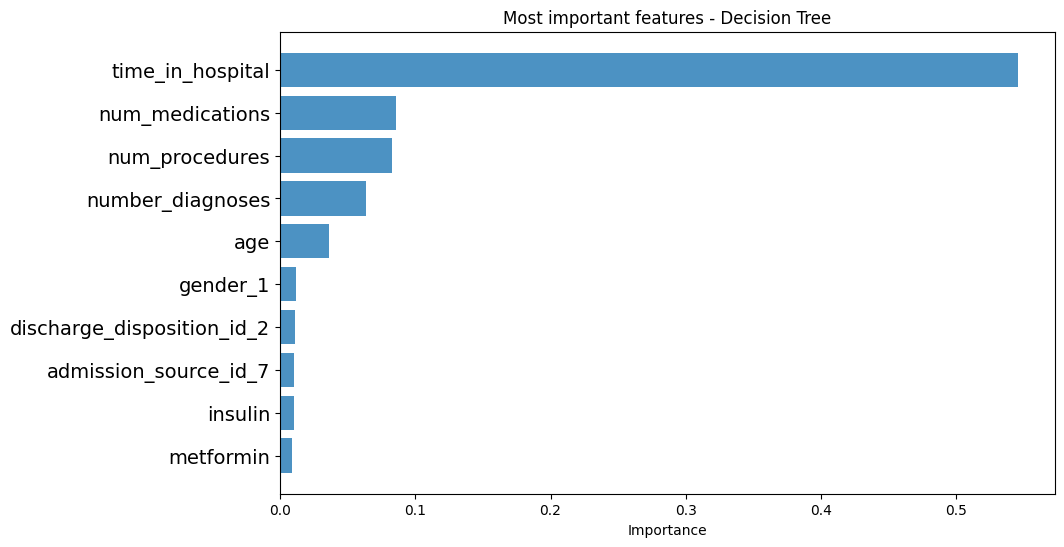

In [151]:
# Create list of top most features based on importance
feature_names = train_input_new.columns
feature_imports = dtree.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

## Random Forest Classifier

In [152]:
X = df_pd[feature_set_no_int]
y = df_pd['readmitted']

In [153]:
print('Original dataset shape {}'.format(Counter(y)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

Original dataset shape Counter({0: 54635, 1: 5071})


In [154]:
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_resample(X_train, y_train)
print('New dataset shape {}'.format(Counter(train_output_new)))
train_input_new = pd.DataFrame(train_input_new, columns = list(X_train.columns))

New dataset shape Counter({0: 43711, 1: 43711})


In [155]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rm.fit(train_input_new, train_output_new)

RandomForestClassifier(max_depth=25, min_samples_split=10, n_estimators=10)

In [156]:
rm_prd = rm.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(rm_prd, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,1290,176,1466
1,145,22,167
All,1435,198,1633


In [157]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, rm_prd)))

accuracy_rm = accuracy_score(y_test, rm_prd)
precision_rm = precision_score(y_test, rm_prd)
recall_rm = recall_score(y_test, rm_prd)

Accuracy is 0.82
Precision is 0.11
Recall is 0.15


             Feature  Importance
13         glipizide        0.02
42  level1_diag1_3.0        0.02
38       A1Cresult_0        0.02
39       A1Cresult_1        0.03
8          metformin        0.03
0                age        0.05
7   number_diagnoses        0.08
3    num_medications        0.08
2     num_procedures        0.10
1   time_in_hospital        0.20


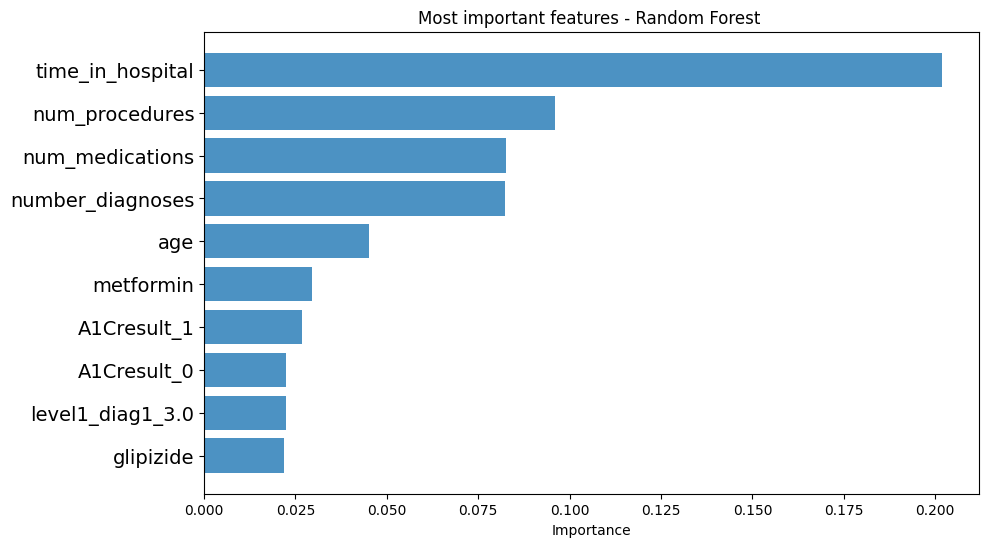

In [158]:
# Create list of top most features based on importance
feature_names = train_input_new.columns
feature_imports = rm.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

# Model Comparison

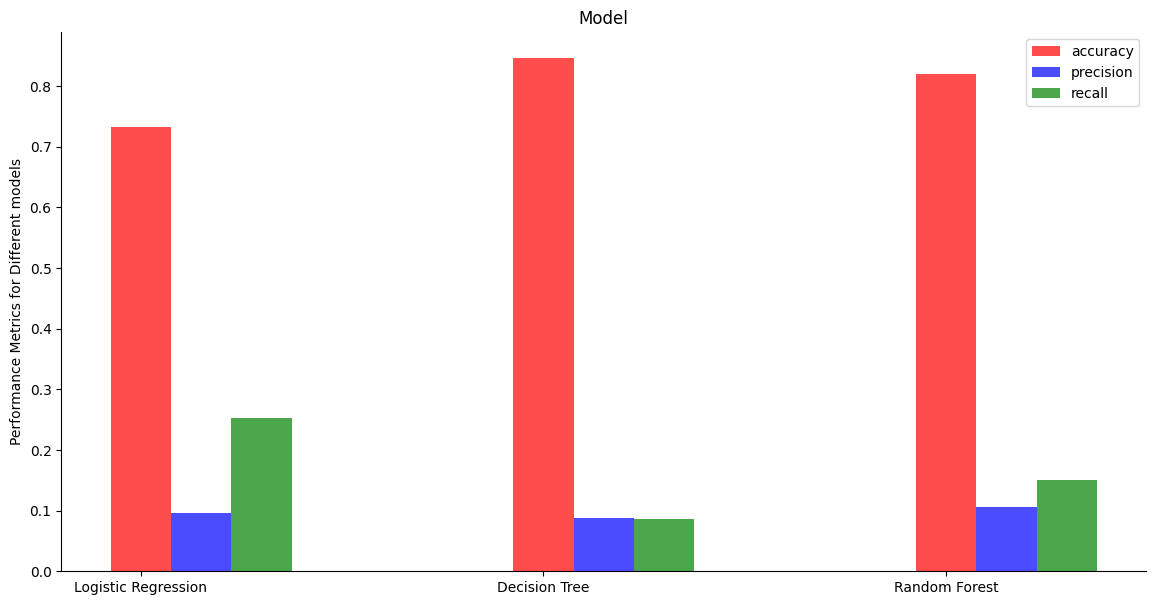

In [160]:
plt.figure(figsize=(14, 7))
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
values = [accuracy_logit, accuracy_dtree, accuracy_rm]
model = np.arange(len(models))

plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'accuracy')
plt.xticks(model, models)
           

           
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
values = [precision_logit, precision_dtree, precision_rm]
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'precision')
plt.xticks(model, models)



ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forest' ]
values = [recall_logit, recall_dtree, recall_rm, ]
model = np.arange(len(models))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'green', label = 'recall')
plt.xticks(model, models)



plt.ylabel('Performance Metrics for Different models')
plt.title('Model')
    
# removing the axis on the top and right of the plot window
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show() 

In [162]:
X = df_pd[feature_set_no_int]
y = df_pd['readmitted']
df_pd['readmitted'].value_counts()

0    54635
1     5071
Name: readmitted, dtype: int64

In [163]:
print('Original dataset shape {}'.format(Counter(y)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

Original dataset shape Counter({0: 54635, 1: 5071})


In [164]:
# No smote
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

 41%|████▏     | 12/29 [27:04<2:05:10, 441.81s/it]

: 